[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/map-reduce.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239947-lesson-3-map-reduce)

# Map-reduce

## Review

We're building up to a multi-agent research assistant that ties together all of the modules from this course.

To build this multi-agent assistant, we've been introducing a few LangGraph controllability topics.

We just covered parallelization and sub-graphs.

## Goals

Now, we're going to cover [map reduce](https://docs.langchain.com/oss/python/langgraph/use-graph-api#map-reduce-and-the-send-api).

In [30]:
%%capture --no-stderr
%pip install -U langchain_openai langgraph

In [1]:
import os
import getpass
import google.generativeai as genai
from dotenv import load_dotenv

# Load environment variables from .env
load_dotenv(dotenv_path="../../.env", override=True)

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

# Prefer GOOGLE_API_KEY from .env; fallback to prompt
_set_env("GOOGLE_API_KEY")

# Configure Gemini model
genai.configure(api_key=os.environ["GOOGLE_API_KEY"])

model = genai.GenerativeModel("gemini-2.5-flash")



c:\Users\rishi\LLM_prac\LangGraph\.env_lang\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We'll use [LangSmith](https://docs.langchain.com/langsmith/home) for [tracing](https://docs.langchain.com/langsmith/observability-concepts).

In [2]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## Problem

Map-reduce operations are essential for efficient task decomposition and parallel processing. 

It has two phases:

(1) `Map` - Break a task into smaller sub-tasks, processing each sub-task in parallel.

(2) `Reduce` - Aggregate the results across all of the completed, parallelized sub-tasks.

Let's design a system that will do two things:

(1) `Map` - Create a set of jokes about a topic.

(2) `Reduce` - Pick the best joke from the list.

We'll use an LLM to do the job generation and selection.

In [3]:
from langchain_google_genai import ChatGoogleGenerativeAI
import os

# Prompts we will use
subjects_prompt = """Generate a list of 3 sub-topics that are all related to this overall topic: {topic}."""
tweet_prompt = """Generate a short, funny tweet about {subject}."""
best_tweet_prompt = """Below are a bunch of tweets about {topic}. Select the best one! Return the ID of the best one, starting 0 as the ID for the first tweet. Tweets: \n\n  {tweets}"""

# LLM (use API key from .env to avoid ADC)
model = ChatGoogleGenerativeAI(
    model="gemini-2.5-pro",
    google_api_key=os.getenv("GOOGLE_API_KEY"),
    temperature=0,
)


## State

### Parallelizing joke generation

First, let's define the entry point of the graph that will:

* Take a user input topic
* Produce a list of joke topics from it
* Send each joke topic to our above joke generation node

Our state has a `jokes` key, which will accumulate jokes from parallelized joke generation

In [5]:
import operator
from typing import Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel

class Subjects(BaseModel):
    subjects: list[str]

class BestTweet(BaseModel):
    id: int

class OverallState(TypedDict):
    topic: str
    subjects: list
    tweets: Annotated[list, operator.add]
    best_selected_tweet: str


Generate subjects for jokes.

In [6]:
import time

def generate_topics(state: OverallState):
    time.sleep(30)  # wait 30 seconds between Gemini calls
    prompt = subjects_prompt.format(topic=state["topic"])
    response = model.with_structured_output(Subjects).invoke(prompt)
    return {"subjects": response.subjects}


Here is the magic: we use the  [Send](https://docs.langchain.com/oss/python/langgraph/graph-api/#send) to create a joke for each subject.

This is very useful! It can automatically parallelize joke generation for any number of subjects.

* `generate_joke`: the name of the node in the graph
* `{"subject": s`}: the state to send

`Send` allow you to pass any state that you want to `generate_joke`! It does not have to align with `OverallState`.

In this case, `generate_joke` is using its own internal state, and we can populate this via `Send`.

In [7]:
from langgraph.types import Send

def continue_to_tweets(state: OverallState):
    return [Send("generate_tweet", {"subject": s}) for s in state["subjects"]]



### Joke generation (map)

Now, we just define a node that will create our jokes, `generate_joke`!

We write them back out to `jokes` in `OverallState`! 

This key has a reducer that will combine lists.

In [8]:
class TweetState(TypedDict):
    subject: str

class Tweet(BaseModel):
    tweet: str
import time

def generate_tweet(state: TweetState):
    time.sleep(45)  # throttle to avoid Gemini rate limits
    subject = state["subject"]
    prompt = tweet_prompt.format(subject=subject)
    response = model.invoke(prompt)
    tweet_text = response.content if hasattr(response, "content") else str(response)
    return {"tweets": [tweet_text]}



### Best joke selection (reduce)

Now, we add logic to pick the best joke.

In [9]:
def best_tweet(state: OverallState):
    tweets = "\n\n".join(state["tweets"])
    prompt = best_tweet_prompt.format(topic=state["topic"], tweets=tweets)
    response = model.with_structured_output(BestTweet).invoke(prompt)
    return {"best_selected_tweet": state["tweets"][response.id]}



## Compile

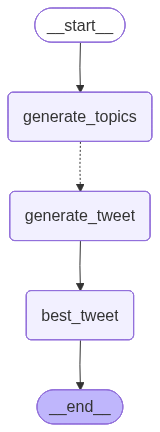

In [10]:
from IPython.display import Image
from langgraph.graph import END, StateGraph, START

# Construct the graph
graph = StateGraph(OverallState)
graph.add_node("generate_topics", generate_topics)
graph.add_node("generate_tweet", generate_tweet)
graph.add_node("best_tweet", best_tweet)

# Define the flow
graph.add_edge(START, "generate_topics")
graph.add_conditional_edges("generate_topics", continue_to_tweets, ["generate_tweet"])
graph.add_edge("generate_tweet", "best_tweet")
graph.add_edge("best_tweet", END)

# Compile and visualize
app = graph.compile()
Image(app.get_graph().draw_mermaid_png())


In [11]:
# Call the graph: here we call it to generate a list of jokes
for s in app.stream({"topic": "the moon"}):
    print(s)

{'generate_topics': {'subjects': ['the moon']}}
{'generate_tweet': {'tweets': ['The moon is so dramatic. One minute it’s all big and bright, the next it’s giving you the silent treatment. Make up your mind.']}}
{'best_tweet': {'best_selected_tweet': 'The moon is so dramatic. One minute it’s all big and bright, the next it’s giving you the silent treatment. Make up your mind.'}}


## Studio

**⚠️ Notice**

Since filming these videos, we've updated Studio so that it can now be run locally and accessed through your browser. This is the preferred way to run Studio instead of using the Desktop App shown in the video. It is now called _LangSmith Studio_ instead of _LangGraph Studio_. Detailed setup instructions are available in the "Getting Setup" guide at the start of the course. You can find a description of Studio [here](https://docs.langchain.com/langsmith/studio), and specific details for local deployment [here](https://docs.langchain.com/langsmith/quick-start-studio#local-development-server).  
To start the local development server, run the following command in your terminal in the `/studio` directory in this module:

```
langgraph dev
```

You should see the following output:
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

Open your browser and navigate to the **Studio UI** URL shown above.

Let's load the above graph in the Studio UI, which uses `module-4/studio/map_reduce.py` set in `module-4/studio/langgraph.json`.